In [1]:
from astropy import units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS
from astropy.coordinates import SkyCoord
from astropy.table import QTable, unique
from astropy.time import Time
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
import plot_utils as pu

backgroundcolour = "#171726"
foregroundcolour = "#FFF"

cmap = LinearSegmentedColormap.from_list("sky", [backgroundcolour, foregroundcolour])

Simbad.reset_votable_fields()

generic_maximum_magnitude = 10

spectral_colours = {'O':'blue',
                    'B':'pale blue',
                    'A':'blue-white',
                    'F':'white',
                    'G':'cream',
                    'K':'orange',
                    'M':'orange'}

In [2]:
Simbad.list_votable_fields().show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

## User Inputs

In [3]:
location = "Toronto"
observation_point = (
    40*u.deg,
    140*u.deg
)  # altitude (deg from horizon), azimuth (eastwards from north)
utc_conversion = -4 * u.hour
datetime = Time("2025-02-18 19:00:00") - utc_conversion

view_radius = 15*u.deg
maximum_magnitude = 3

image_pixels = 500

## Convert Observing Point to RA/Dec

In [4]:
# query to a lat/long
earth_location = EarthLocation.of_address(location)

# generate a coordinate frame for the observation
earth_frame = AltAz(
    obstime=datetime,
    az=observation_point[1],
    alt=observation_point[0],
    location=earth_location,
)

# perform the conversion
ra_dec = earth_frame.transform_to(ICRS())

## Query SIMBAD to get a catalogue of objects with relevant data

In [5]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields("flux", "sp_type")
criteria = f"otype != 'err' AND flux < {generic_maximum_magnitude}"
query_result = QTable(
    Simbad.query_region(ra_dec, radius=view_radius, criteria=criteria)
)

# clean up the result
columns_to_remove = [
    "coo_err_min",
    "coo_err_angle",
    "coo_wavelength",
    "coo_bibcode",
    "coo_err_maj",
    "bibcode",
    "flux_err",
    "flux_err_prec",
    "flux_prec",
    "qual",
]
for colname in columns_to_remove:
    query_result.remove_column(colname)

# rename columns
query_result.rename_column("main_id", "id")
query_result.rename_columns(("filter", "flux"), ("magnitude.filter", "magnitude"))
query_result.rename_column("sp_type", "spectral_type")

# round columns
query_result["ra"] = query_result["ra"].round(5)
query_result["dec"] = query_result["dec"].round(5)
query_result["magnitude"] = query_result["magnitude"].round(3)
query_result["spectral_type"] = [i[0] if len(i) > 0 else "" for i in query_result["spectral_type"]]

In [6]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields("flux")
criteria = f"otype != 'err' AND flux < {generic_maximum_magnitude}"
query_result = QTable(Simbad.query_region(ra_dec, radius=view_radius, criteria=criteria))

# clean up the result
columns_to_remove = [
    "coo_err_min",
    "coo_err_angle",
    "coo_wavelength",
    "coo_bibcode",
    "coo_err_maj",
    "bibcode",
    "flux_err",
    "flux_err_prec",
    "flux_prec",
    "qual",
]
for colname in columns_to_remove:
    query_result.remove_column(colname)

# rename columns
query_result.rename_column("main_id", "id")
query_result.rename_columns(("filter", "flux"), ("magnitude.filter", "magnitude"))

# round columns
query_result["ra"] = query_result["ra"].round(5)
query_result["dec"] = query_result["dec"].round(5)
query_result["magnitude"] = query_result["magnitude"].round(3)

## Filter data

In [7]:
# only keep items with magnitudes measured in visible
query_result = query_result[query_result['magnitude.filter'] == "V"]

# only keep items with magnitudes less than the given maximum
query_result = query_result[query_result['magnitude'] < maximum_magnitude]

query_result = unique(query_result)

In [8]:
query_result.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

## Calculate image parameters

In [9]:
wcs = WCS(naxis=2)
wcs.wcs.crpix = [image_pixels / 2] * 2

degrees_per_pixel = (view_radius / (image_pixels / 2)).to(u.deg).value
wcs.wcs.cdelt = [degrees_per_pixel, degrees_per_pixel]
wcs.wcs.crval = [ra_dec.ra.value, ra_dec.dec.value]
wcs.wcs.ctype = ["RA", "DEC"]
wcs.wcs.cunit = [u.deg, u.deg]

query_result['flux'] = 10**(-query_result['magnitude']/2.5) # relative to V-band reference flux

wavelength = 0.55 * u.micron # https://en.wikipedia.org/wiki/Apparent_magnitude#Standard_reference_values

aperture_diameter = 3*u.mm # pupil size

airy_disk_minimum = (1.22 * wavelength / aperture_diameter).decompose() * u.rad # radians from centre
airy_disk_pixels = airy_disk_minimum.to(u.deg) / (degrees_per_pixel*u.deg)

# assume the airy disk is at 3x standard deviation of the Gaussian
std_dev = airy_disk_pixels / 3

# standard deviation is "diameter" whilst airy is "radius"
std_dev *= 2

print(std_dev)

def intensity(radius, flux, sigma):
    '''
    How much light is observed from a star at some radius away from it
    '''
    coefficient = flux / (sigma * np.sqrt(2*np.pi))
    exponential = np.exp(- radius**2 / (sigma**2))

    return coefficient * exponential

0.14239062241954906


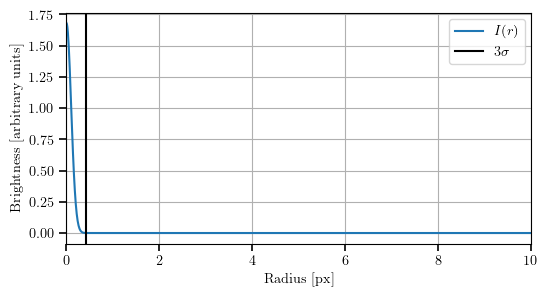

In [10]:
radius = np.linspace(0,10,1000)
brightness = [intensity(r,0.6,std_dev) for r in radius]
fig, ax = pu.fig_setup(figsize=(6,3))
ax.plot(radius, brightness, label='$I(r)$')
ax.set(xlabel='Radius [px]', ylabel='Brightness [arbitrary units]', xlim=radius[[0,-1]])
ax.axvline(3 * std_dev, c='k', label='$3\\sigma$')
ax.grid()
ax.legend()
plt.show()

In [11]:
std_dev = 3

## Add stars to image

In [12]:
image = np.zeros((image_pixels, image_pixels))

maxradius = 5*std_dev
radius_vector = np.arange(-maxradius,maxradius+1).astype(int)
area = np.array(np.meshgrid(radius_vector, radius_vector)) # mesh of points which will map to around the star

radial_distance = np.sqrt(area[0]**2 + area[1]**2)

unique_radii = np.unique(radial_distance)

# all of the locations where each unique radius is found
radius_locations = [np.array(np.where(radial_distance == radius)).T for radius in unique_radii]


for ra,dec,flux in query_result[['ra', 'dec', 'flux']]:
    skycoord = SkyCoord(ra=ra, dec=dec)
    x,y = np.round(skycoord.to_pixel(wcs)).astype(int)

    # do all points at some given radius at once
    for radius, points in zip(unique_radii, radius_locations):
        brightness = intensity(radius, flux, std_dev)

        for x_,y_ in points:
            # get the actual distance from the star in pixels
            x__ = x + area[1][x_,y_]
            y__ = y + area[0][x_,y_]

            if (0<=x__<image.shape[1]) and (0<=y__<image.shape[0]):
                image[y__,x__] += brightness

## Plot result

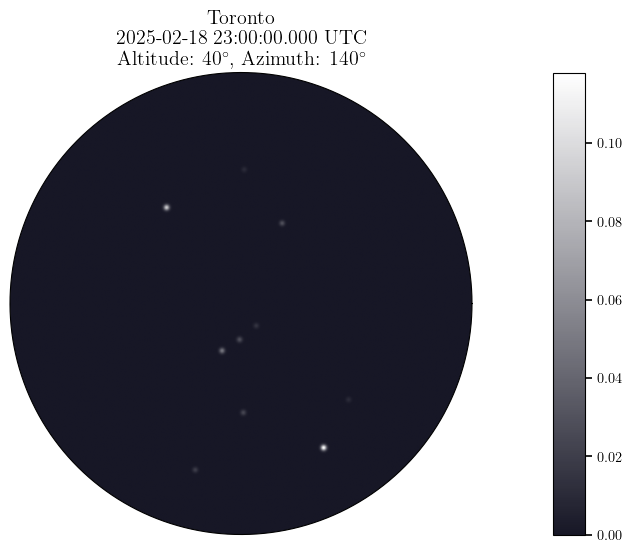

/home/taiwithers/projects/skysim/mvp/SkySim.png saved.


In [13]:
fig, ax = pu.fig_setup(wcs=wcs, plot_kwargs={'frame_class':EllipticalFrame})

norm = LogNorm(vmin=1e-5, vmax=np.max(image), clip=True)
im = ax.imshow(image, cmap=cmap)#, norm=norm)

pu.add_colorbar(im, fig=fig, ax=ax)

pu.style_wcs_axes(ax, axis_ticks=(False,False))

ax.invert_xaxis()

location_string = f'{location}'
datetime_string = f'{datetime} UTC'
altaz_string = f"Altitude: {observation_point[0].to_string(format="latex")}, Azimuth: {observation_point[1].to_string(format="latex")}"
ax.set_title(f'{location_string}\n{datetime_string}\n{altaz_string}')

plt.show()

pu.save_fig(fig, 'SkySim')